# CIROH Developers Conference: Hydrological Applications of ML
## CNNs for Predicting Daily Orographic Precipitation Gradients for Atmospheric Downscaling

#### A good place to start is familiarizing ourselves with the dataset. First we'll take a look at facets, precipitation, and OPGs

In [1]:
# Global imports
import pandas as pd
import csv

from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

import nclcmaps as ncm

#### Lets load in the topogrphic elevations, labeled facets, facet orientations, latitudes, longitudes, and orographic precipitation gradients

#### Facets are defined as regions which have the same general facing orientation, determined using the Gibson et al. (1997) algorithm which accounts for the orientation of each grid point and its surrounding gridpoints to bin orientations. We'll plot what these look like in following cells.

In [2]:
path = "../datasets/facets_and_opgs/"

facets = np.array(pd.read_csv(f"{path}facet_labels.csv", index_col=0))
lats = np.array(pd.read_csv(f"{path}lats.csv", index_col=0))
lons = np.array(pd.read_csv(f"{path}lons.csv", index_col=0))
orientation = np.array(pd.read_csv(f"{path}facet_orientation.csv", index_col=0))
opg = pd.read_csv(f"{path}winter_northernUT_opg.csv", index_col=0)

#### Below, lets plot the region of study, Northern Utah and the facets we will will be predicting orographic precipitation gradients.

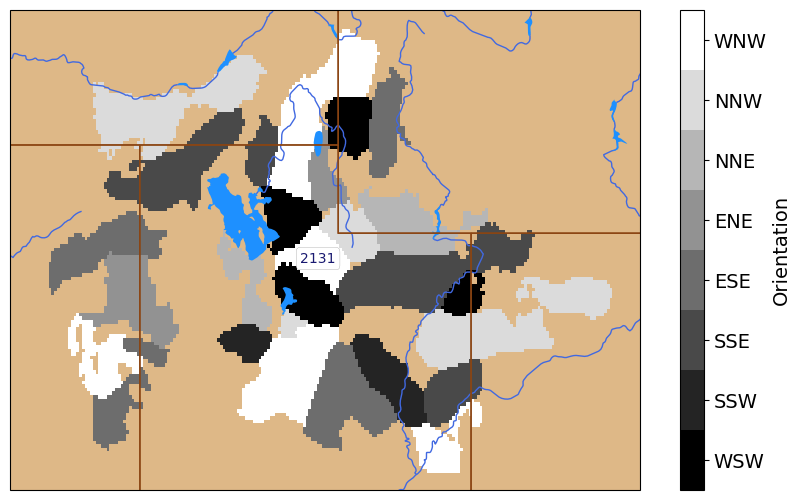

In [3]:
# Plot Northern Utah

# Define a custom colormap
cmap_fi = ListedColormap([[0.0, 0.0, 0.0],[0.1428, 0.1428, 0.1428],[0.2857, 0.2857, 0.2857],
           [0.4285, 0.4285, 0.4285],[0.5714, 0.5714, 0.5714],[0.7142, 0.7142, 0.7142],
           [0.8571, 0.8571, 0.8571],[1.0, 1.0, 1.0]])

# set flat facets to nan to remove from plot
orientx = orientation.astype('float')
orientx[orientx == 9] = np.nan 

# Preset Variables
extent = [-116, -106.5, 38, 43.5] # extent of plotting window in lons then lats
datacrs = ccrs.PlateCarree()

# Create Figure
fig = plt.figure( figsize = (10, 6))
ax = fig.add_axes( [0.1, 0.1, 0.8, 0.8], projection = ccrs.Mercator(central_longitude=np.mean(lons)) )

# Plot Facets and Shade Them Based On Their Orientation
pcm = ax.pcolormesh(lons, lats, orientx, cmap=cmap_fi, transform=datacrs, shading='auto')
pcm.set_clim(0.5,8.5)

# Add label on facet 2131
plt.text(np.median(lons[facets==2131]), np.median(lats[facets==2131]), str(2131), fontsize = 10, color = 'midnightblue', 
              transform = datacrs, ha = 'center', va = 'center', bbox=dict(boxstyle="round", fc=(1,1,1), linewidth=0.1))

# Cartography Features
ax.add_feature(cfeat.LAND, facecolor="burlywood")
ax.add_feature(cfeat.RIVERS.with_scale('10m'), edgecolor="royalblue")
ax.add_feature(cfeat.LAKES.with_scale('10m'), facecolor="dodgerblue")
ax.add_feature(cfeat.STATES.with_scale('10m'), edgecolor="saddlebrown")
ax.set_extent(extent)

# Add colorbar
cbar = plt.colorbar(pcm, ticks=[0,1,2,3,4,5,6,7,8,9])
cbar.set_label("Orientation", fontsize=14)
cbar.ax.set_yticklabels(['','WSW','SSW','SSE','ESE','ENE','NNE','NNW','WNW',''])
cbar.ax.tick_params(labelsize=14)

# Save and Show Figure
path = "../figures/"
plt.savefig(f"{path}facet_orientations.png", dpi=200, transparent=True,  bbox_inches='tight')
plt.show()

#### Each of the above shaded regions are a facet, determined by the facing orientation of the topography. The total number of facets in our dataset is 30, but lets take a closer look at the data within facet 2131, labeled above.

#### The timeseries of OPGs from facet 2131 is plotted below:

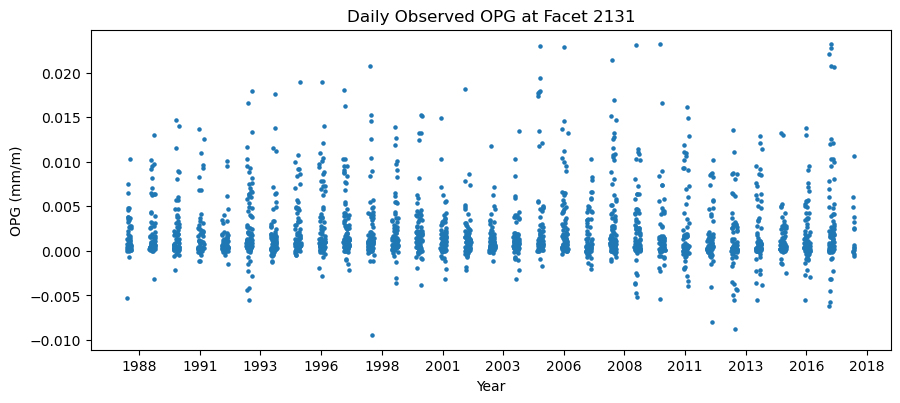

In [4]:
# reformat dates for plotting
xdata = opg.index
xdata = [datetime.strptime(x, '%Y-%m-%d') for x in xdata]

# Create figure
fig = plt.figure( figsize = (10, 4))
ax = fig.add_axes( [0.1, 0.1, 0.8, 0.8])

# Plot OPGs as scatter plots
plt.scatter(xdata, opg["2131"], s=5)

# Set labels
plt.xlabel("Year")
plt.ylabel("OPG (mm/m)")
plt.title("Daily Observed OPG at Facet 2131")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Save and Show Figure
path = "../figures/"
plt.savefig(f"{path}opg_timeseries_facet2131.png", dpi=200, transparent=True,  bbox_inches='tight')
plt.show()

#### In the following script we will create a Convolutional Neural Network (CNN) to predict the OPGs on the show facets. The predictors used are the following atmospheric variables from the ERA5:
- IVT
- Accumulated precipitation
- 700 hPa temperatures
- 700 hPa U-Winds
- 700 hPa V-Winds
- 500 hPa geopotential heights

#### To get an understanding of these variables, lets plot a few days of these variables

In [17]:
import xarray as xr

path = "../datasets/era5_atmos/"

IVT       = xr.open_dataset(f"{path}IVT_sfc.nc")
precip    = xr.open_dataset(f"{path}precip_sfc.nc")*1000
temp700   = xr.open_dataset(f"{path}temp_700.nc")-273.15
uwinds700 = xr.open_dataset(f"{path}uwnd_700.nc")
vwinds700 = xr.open_dataset(f"{path}vwnd_700.nc")
hgt500    = xr.open_dataset(f"{path}hgt_500.nc")/9.81

In [28]:
# Subset to a good week
dates = ["1996-02-18", "1996-02-23"]

IVT       = IVT.sel(time=slice(dates[0], dates[1]))
precip    = precip.sel(time=slice(dates[0], dates[1]))
temp700   = temp700.sel(time=slice(dates[0], dates[1]))
uwinds700 = uwinds700.sel(time=slice(dates[0], dates[1]))
vwinds700 = vwinds700.sel(time=slice(dates[0], dates[1]))
hgt500    = hgt500.sel(time=slice(dates[0], dates[1]))

[-119.  -118.5 -118.  -117.5 -117.  -116.5 -116.  -115.5 -115.  -114.5
 -114.  -113.5 -113.  -112.5 -112.  -111.5 -111.  -110.5 -110.  -109.5
 -109.  -108.5 -108.  -107.5 -107.  -106.5 -106. ]


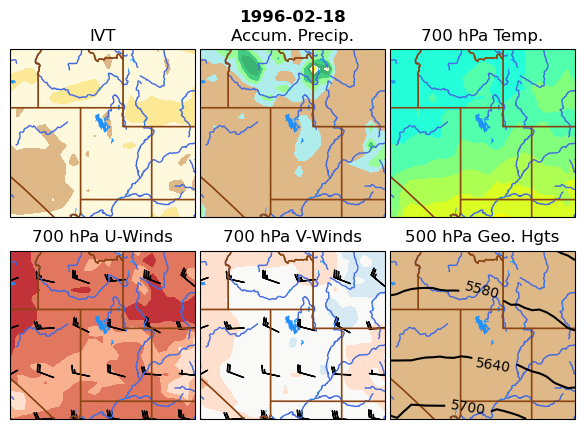

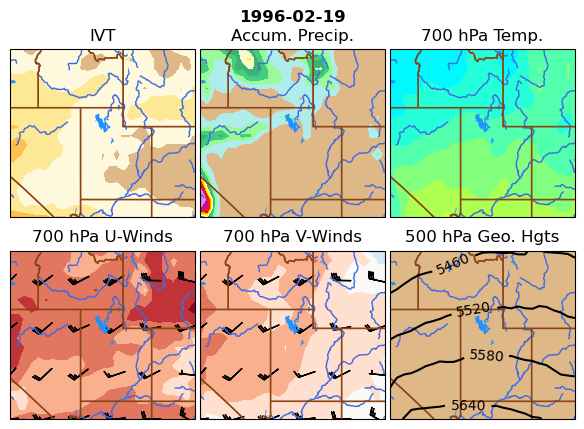

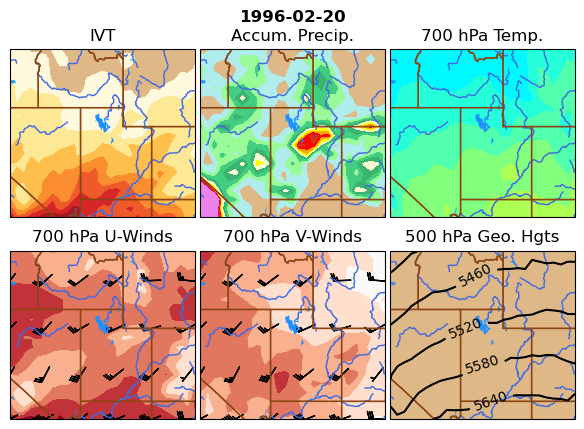

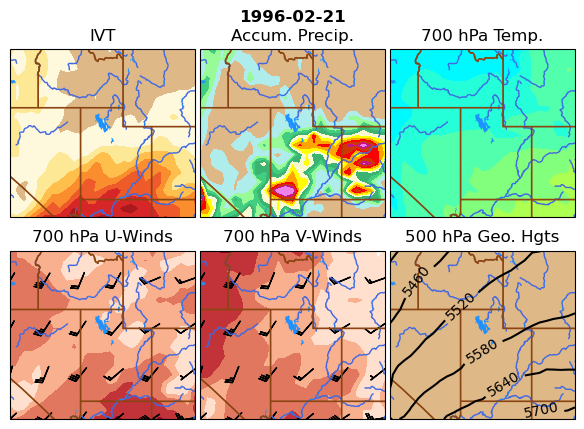

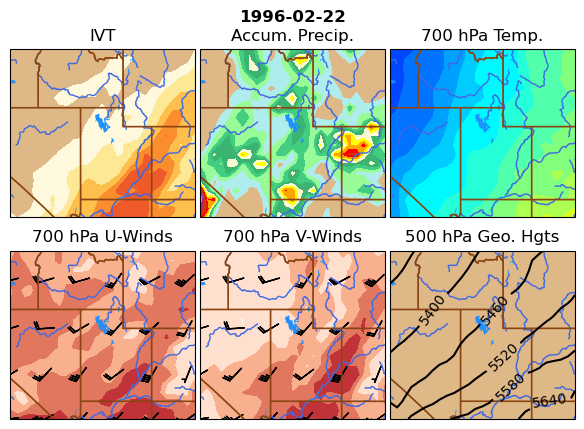

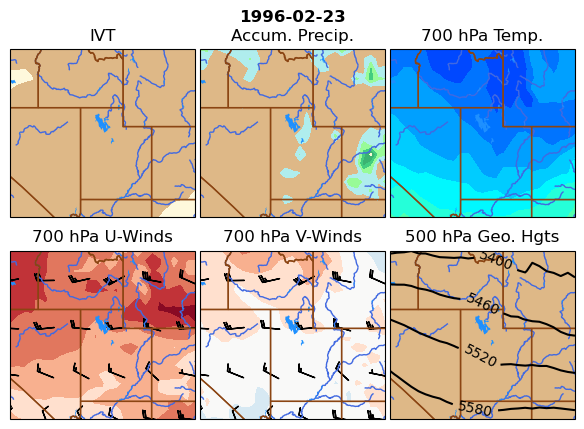

In [30]:
# plotting

# Plot Transforms
datacrs = ccrs.PlateCarree()
projex = ccrs.Mercator(central_longitude=np.mean(lons))
extent = [-119, -106, 36, 45]

# Loop through each day
for dayx in range(len(IVT.time.values)):
    
    # Create figure
    fig, axs = plt.subplots(2, 3, figsize = (6, 4), subplot_kw={'projection': projex})
    fig.tight_layout()
    
    # Plot IVT
    axs[0, 0].contourf(IVT.longitude, IVT.latitude, IVT.IVT.values[dayx,:,:], 
                       cmap=ncm.cmap('WhiteYellowOrangeRed'), levels=np.arange(100, 500, 50), extend='max', transform=datacrs)
    axs[0, 0].set_title("IVT")
    
    # Plot accumulated precipitation
    axs[0, 1].contourf(precip.longitude, precip.latitude, precip.precip.values[dayx,:,:], 
                       cmap=ncm.cmapDiscrete('prcp_2', indexList=np.arange(1,12)), levels=np.arange(0.5, 6.5, 0.5), extend='max', transform=datacrs)
    axs[0, 1].set_title("Accum. Precip.")
    
    # Plot 700 hPa temperatures
    axs[0, 2].contourf(temp700.longitude, temp700.latitude, temp700.temp.values[dayx,:,:], 
                       cmap=ncm.cmap('NCV_jet'), levels=np.arange(-24, 24, 2), transform=datacrs)
    axs[0, 2].set_title("700 hPa Temp.")
    
    # Plot 700 hPa U-winds
    axs[1, 0].contourf(uwinds700.longitude, uwinds700.latitude, uwinds700.uwnd.values[dayx,:,:], 
                       cmap=ncm.cmap('MPL_RdBu', True), levels=np.arange(-30, 30, 5), transform=datacrs)
    axs[1, 0].set_title("700 hPa U-Winds")
    
    # Plots 700 hPa V-winds
    axs[1, 1].contourf(vwinds700.longitude, vwinds700.latitude, vwinds700.vwnd.values[dayx,:,:], 
                       cmap=ncm.cmap('MPL_RdBu', True), levels=np.arange(-30, 30, 5), transform=datacrs)
    axs[1, 1].set_title("700 hPa V-Winds")

    # Add wind barbs
    u700 = uwinds700.uwnd.values[dayx,::5,::5] * 1.94384  
    v700 = vwinds700.vwnd.values[dayx,::5,::5] * 1.94384
    axs[1, 0].barbs(uwinds700.longitude[::5], uwinds700.latitude[::5], u700, v700, length=6, pivot='middle', transform=datacrs)
    axs[1, 1].barbs(uwinds700.longitude[::5], uwinds700.latitude[::5], u700, v700, length=6, pivot='middle', transform=datacrs)
    
    # Plots 500 hPa geopotential heights
    cs = axs[1, 2].contour(hgt500.longitude, hgt500.latitude, hgt500.hgt.values[dayx,:,:], 
                      colors='black', levels=np.arange(5160, 5880, 60), transform=datacrs)
    axs[1, 2].clabel(cs, fmt="%d", inline = True)
    axs[1, 2].set_title("500 hPa Geo. Hgts")
    
    # Add Cartogrphy
    for row in range(2):
        for col in range(3):
            axs[row,col].add_feature(cfeat.LAND, facecolor="burlywood")
            axs[row,col].add_feature(cfeat.RIVERS.with_scale('10m'), edgecolor="royalblue")
            axs[row,col].add_feature(cfeat.LAKES.with_scale('10m'), facecolor="dodgerblue")
            axs[row,col].add_feature(cfeat.STATES.with_scale('10m'), edgecolor="saddlebrown")
            axs[row,col].set_extent(extent)

    # adjust plot
    plt.subplots_adjust(wspace=0, hspace=0.2)
    datex = np.datetime_as_string(IVT.time.values[dayx], unit="D")
    plt.suptitle(datex, y=1.06, weight='bold')

    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}atmos_{datex}.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()



#### The above plots display the 6 predictor variables we will use today to predict OPGs in Northern Utah.
